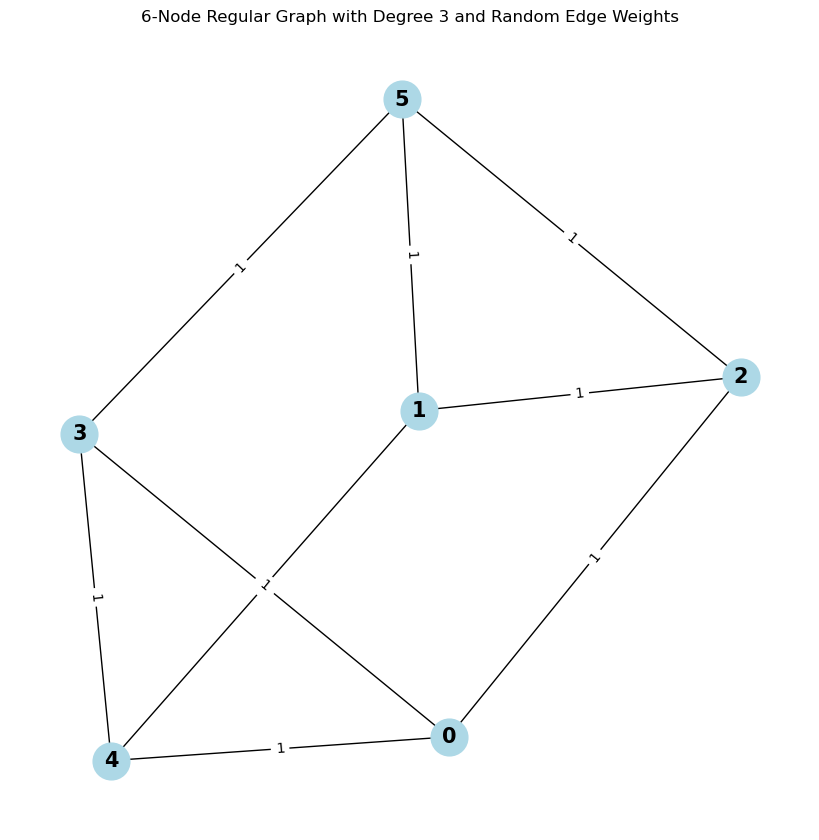

In [2]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info import Pauli

# 生成一个度为 3 的正则图（6个顶点）
n = 6  # 顶点数
degree = 3  # 每个顶点的度数

# 创建正则图
G = nx.random_regular_graph(degree, n)

# 为每条边分配一个随机的权重（在 [0, 1] 范围内）
# for u, v in G.edges():
#     G[u][v]['weight'] = np.random.uniform(0, 1)
for u, v in G.edges():
    G[u][v]['weight'] = 1
# 计算节点的位置（使用 spring_layout 或其他布局方法）
pos = nx.spring_layout(G, seed=42)  # 使用 Spring 布局计算节点位置

# 绘制图形
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=15, font_weight='bold')

# 显示边的权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 显示图形
plt.title("6-Node Regular Graph with Degree 3 and Random Edge Weights")
plt.show()
N = G.number_of_nodes()
# print(len(bw))


In [3]:
# def pauli_z_term(index, num_qubits):
#     """初始化一个 Pauli-I 门的列表,指定索引 index 替换为 Pauli-Z 门"""
#     paulis = ['I'] * num_qubits
#     paulis[index] = 'Z'
#     return ''.join(paulis)  # 将列表转化为字符串
def pauli_z_term(indices, num_qubits):
    """生成 Pauli-Z 项"""
    z_str = ['I'] * num_qubits
    for idx in indices:
        z_str[idx] = 'Z'
    return ''.join(z_str)


def pauli_x_term(index, num_qubits):
    paulis = ['I'] * num_qubits
    paulis[index] = 'X'
    return ''.join(paulis)

In [4]:
from qiskit.quantum_info import SparsePauliOp

# 初始化 Pauli 字符串和系数
pauli_strings = []
coefficients = []

# 构建最大割问题的哈密顿量
for u, v in G.edges():
    weight = G[u][v]['weight']

    # 创建 Pauli 字符串
    z_term = ['I'] * N  # 假设有 n 个量子比特
    z_term[u] = 'Z'  # 在节点 u 上应用 Pauli Z
    z_term[v] = 'Z'  # 在节点 v 上应用 Pauli Z

    # 将 Pauli 字符串加入列表
    pauli_strings.append(''.join(z_term))

    # 系数是边权重的一半
    coefficients.append(weight / 2)

# 转换为 SparsePauliOp 格式
hamiltonian = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出哈密顿量
print(hamiltonian)


SparsePauliOp(['IZZIII', 'IZIIIZ', 'IZIIZI', 'ZIZIII', 'IIZIIZ', 'ZIIIZI', 'ZIIZII', 'IIIZZI', 'IIIZIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


In [5]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    if len(qubits) == 1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = qubits[:N - 1]

        target_qubit = qubits[N - 1:]

        n_controls = len(control_qubits)
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])
        qc.rz(gamma, target_qubit[0])
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])

In [6]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(2 * gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(2 * gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [7]:
def get_cost_circuit(gamma, qc):
    for i, j in G.edges():
        append__zz_term(qc, i, j, gamma)
    return qc

In [8]:
def get_mixer_circuit(beta, qc):
    for i in G.nodes():
        append__mixer_term(qc, i, beta)
    return qc

In [9]:
def compute_expection(params, mixer_pool):
    """
    :return: expections for all mixers
    """
    expectations = []
    for mixer in mixer_pool:
        expection, counts = cost_function(params)
        expectations.append(expection)
    return expectations

In [10]:
def invert_counts(s):
    return s[::-1]


def maxcut_obj(x, G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut -= 1
    return cut


from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    length = len(params)
    beta, gamma = params[:length // 2], params[length // 2:]
    qc = QuantumCircuit(N, N)
    qc.h(range(N))
    # 生成 k 层量子线路
    for i in range(length // 2 - 1):
        get_cost_circuit(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(N), range(N))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        E = maxcut_obj(bitstring, G)  #调用函数获得单个字符串能量值
        expectation += E * prob
    return expectation, counts


from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    # result = optimizer.minimize(fun=objective, x0=params)
    result = minimize(
        fun=objective,
        x0=params,
        method='Nelder-Mead',  # 指定优化方法
        options={'xatol': 1e-8, 'disp': True}  # 设置容差和显示选项
    )
    return result

In [12]:
from numpy import ComplexWarning
import warnings
import time

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ComplexWarning)
# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(30):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        result = optimize_qaoa(init_point_temp)
        # print(result.x)
        optimal_params = result.x
        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数
Optimization terminated successfully.
         Current function value: -4.491900
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 1 个参数
Optimization terminated successfully.
         Current function value: -4.491900
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 2 个参数
Optimization terminated successfully.
         Current function value: -4.491900
         Iterations: 25
         Function evaluations: 99
第： 2 层   第 0 个参数
Optimization terminated successfully.
         Current function value: -5.947400
         Iterations: 70
         Function evaluations: 199
第： 2 层   第 1 个参数
Optimization terminated successfully.
         Current function value: -5.947400
         Iterations: 45
         Function evaluations: 185
第： 2 层   第 2 个参数
Optimization terminated successfully.
         Current function value: -5.947400
         Iterations: 45
         Function evaluations: 185
第： 3 层   第 0 个参数
Optimization terminated successfully.
      

优化时间： 45.62349557876587
Optimal parameters: [2.6705564  1.85006736 0.17547939 1.31764616 1.10683633 3.71238521]
Optimal value: -6.6114
Final expectation value: -6.6114
Final measurement counts (filtered): {'001011': 1268, '100011': 1232, '110001': 1207, '110100': 1190, '001110': 1184, '011100': 1172, '011110': 198, '001010': 197, '001111': 196, '100001': 193, '110000': 190, '000011': 186, '101011': 184, '111100': 183, '001100': 182, '010100': 169, '110101': 166, '110011': 160}


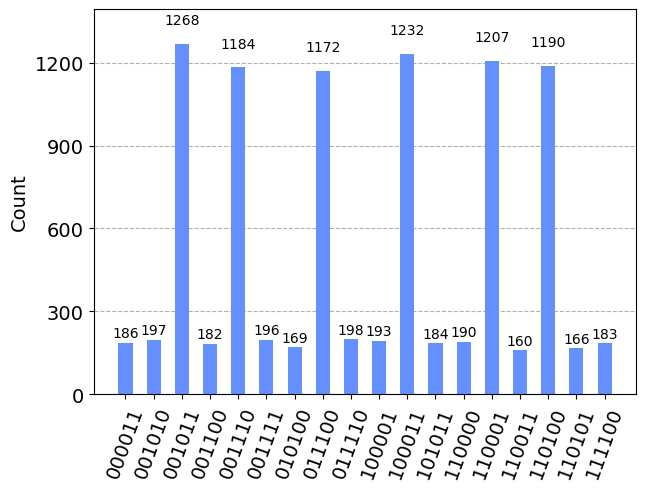

In [13]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
# print("Final measurement counts:", sorted_dict)
print("Final measurement counts (filtered):", filtered_dict)
# plot_histogram(sorted_dict)
# 绘制直方图
plot_histogram(filtered_dict)

<BarContainer object of 6 artists>

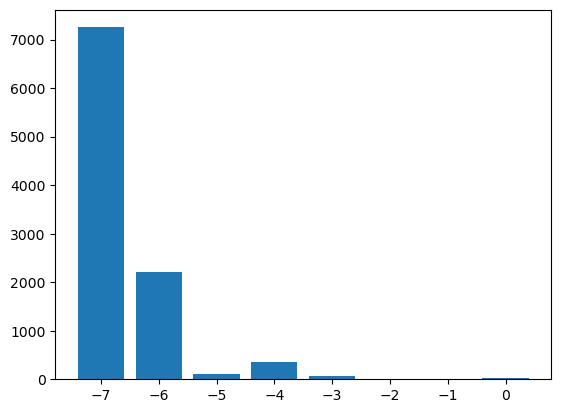

In [14]:
# 创建了一个默认值为 0 的字典 energies，用于存储每个最大割问题能量的计数
energies = defaultdict(int)
# 每个键 k 是一个表示测量结果的字符串，每个值 v 是该测量结果的计数
for k, v in counts.items():
    energies[maxcut_obj(k, G)] += v

# 将字典 energies 中的键值对分别提取出来，分别存储在 x 和 y 中。
# x 是能量值，y 是对应的计数
x, y = zip(*energies.items())
plt.bar(x, y)

Best string: 000111 with cut: 7


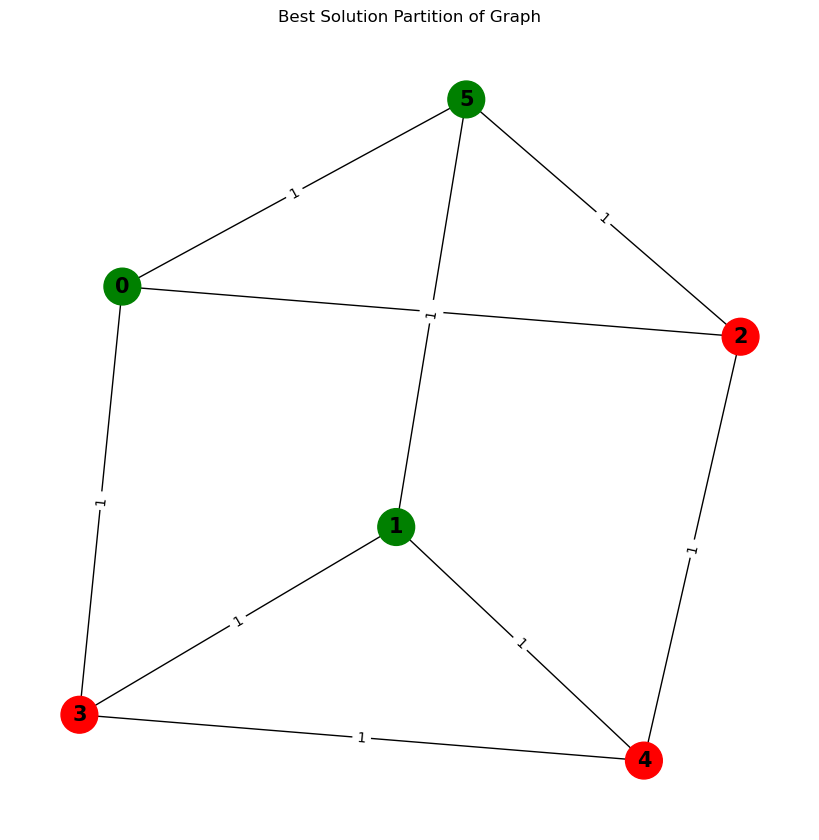

In [51]:
# 从 counts 字典中选择最佳解
best_cut, best_solution = min([(maxcut_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# 根据最佳解对节点进行着色
colors = ['r' if best_solution[i] == '0' else 'g' for i in range(n)]

# 绘制图，使用 spring_layout 或其他布局
pos = nx.spring_layout(G, seed=42)  # 使用 Spring 布局计算节点位置
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color=colors, font_size=15, font_weight='bold')

# 显示边的权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 显示图形
plt.title("Best Solution Partition of Graph")
plt.show()

In [52]:
# 计算期望值
expectation = 0
for bitstring, count in sorted_dict.items():
    bitstring = invert_counts(bitstring)
    prob = count / 10000
    E = maxcut_obj(bitstring, G)  #调用函数获得单个字符串能量值
    expectation += E * prob
print(expectation)

-5.440100000000002


In [53]:
expectation = 0
bitstring = "111000"
E = maxcut_obj(bitstring, G)
print(E)

-7
